# Pathway enrichment by DC
* using pathway gene sets downloaded in 2024-11-26_Pathway-Download.jpynb

# Set up workspace:

In [1]:
#load packages I need
import os
import tools
import scanpy as sc
import pandas as pd
import dandelion as ddl
from tqdm import tqdm
import matplotlib.pyplot as plt
import scanpy.external as sce
from matplotlib.pyplot import rc_context
import seaborn as sns

In [2]:
#show current directory 
os.getcwd()
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')
os.getcwd()

'/scratch/user/s4436039/scdata/Python_Integration_Sep'

Print software versions:

In [3]:
sc.logging.print_header()

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [4]:
ddl.logging.print_header()

dandelion==0.3.8 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.2 networkx==3.3 scipy==1.14.0


In [5]:
# read in data
data = sc.read_h5ad('NRclean_clustered.h5ad')

In [6]:
data

AnnData object with n_obs × n_vars = 498023 × 1268
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample_type', 'cancer_type', 'patient_id', 'sample_id', 'percent.mt', 'site', 'sample_type_major', 'cancer_subtype', 'integration_id', 'ident', 'dataset_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'keep_or_remove', 'leiden', 'celltype', 'leiden_DC', 'leiden_DC_v2', 'exclude_annots', 'leiden_M', 'Technology', 'cancer_type_broad', 'clean-leiden_0.8', 'clean-subcluster', 'clean-subcluster-v2', 'YS_sig', 'HSC_sig', 'CD5nDC2_up_vDC3', 'DC3_up_vCD5nDC2', 'CD5pDC2_up_vDC3', 'DC3_up_vCD5pDC2', 'DC3_up_vMono', 'Mono_up_vDC3', 'DC1_sig', 'DC2_sig', 'DC3_sig', 'DC_Axl_sig', 'DC2_up_DC3', 'DC3_up_DC2', 'mregDC_sig', 'cDC1_mregDC', 'cDC2_mregDC', 'NR_annotati

# Hallmark pathways: 

## Import Hallmark gene sets
* will be imported as a dictionary where each key is a sheet name, and each value is a dataframe (gene set)

In [7]:
os.chdir('/scratch/user/s4436039/scdata/Pathway-sets')
H_sets = pd.read_excel("hallmark_sets.xlsx", sheet_name=None)
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')

In [8]:
# Print the sheet names
print(H_sets.keys())

dict_keys(['Sheet1', 'Sheet2', 'Sheet3', 'Sheet4', 'Sheet5', 'Sheet6', 'Sheet7', 'Sheet8', 'Sheet9', 'Sheet10', 'Sheet11', 'Sheet12', 'Sheet13', 'Sheet14', 'Sheet15', 'Sheet16', 'Sheet17', 'Sheet18', 'Sheet19', 'Sheet20', 'Sheet21', 'Sheet22', 'Sheet23', 'Sheet24', 'Sheet25', 'Sheet26', 'Sheet27', 'Sheet28', 'Sheet29', 'Sheet30', 'Sheet31', 'Sheet32', 'Sheet33', 'Sheet34', 'Sheet35', 'Sheet36', 'Sheet37', 'Sheet38', 'Sheet39', 'Sheet40', 'Sheet41', 'Sheet42', 'Sheet43', 'Sheet44', 'Sheet45', 'Sheet46', 'Sheet47', 'Sheet48', 'Sheet49', 'Sheet50'])


In [9]:
# Change keys to be gene set name (the first value in the 'gs_name' column) instead of Sheet1 etc 
H_sets2 = {df["gs_name"].iloc[0]: df for _, df in H_sets.items()}
H_sets = H_sets2

# Result
print(H_sets.keys())

dict_keys(['HALLMARK_ADIPOGENESIS', 'HALLMARK_ALLOGRAFT_REJECTION', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_ANGIOGENESIS', 'HALLMARK_APICAL_JUNCTION', 'HALLMARK_APICAL_SURFACE', 'HALLMARK_APOPTOSIS', 'HALLMARK_BILE_ACID_METABOLISM', 'HALLMARK_CHOLESTEROL_HOMEOSTASIS', 'HALLMARK_COAGULATION', 'HALLMARK_COMPLEMENT', 'HALLMARK_DNA_REPAIR', 'HALLMARK_E2F_TARGETS', 'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_ESTROGEN_RESPONSE_EARLY', 'HALLMARK_ESTROGEN_RESPONSE_LATE', 'HALLMARK_FATTY_ACID_METABOLISM', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_GLYCOLYSIS', 'HALLMARK_HEDGEHOG_SIGNALING', 'HALLMARK_HEME_METABOLISM', 'HALLMARK_HYPOXIA', 'HALLMARK_IL2_STAT5_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_INTERFERON_ALPHA_RESPONSE', 'HALLMARK_INTERFERON_GAMMA_RESPONSE', 'HALLMARK_KRAS_SIGNALING_DN', 'HALLMARK_KRAS_SIGNALING_UP', 'HALLMARK_MITOTIC_SPINDLE', 'HALLMARK_MTORC1_SIGNALING', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_MYC_TARGETS_V2', 'HALLMAR

In [10]:
H_sets

{'HALLMARK_ADIPOGENESIS':     gs_cat  gs_subcat                gs_name gene_symbol  entrez_gene  \
 0        H        NaN  HALLMARK_ADIPOGENESIS       ABCA1           19   
 1        H        NaN  HALLMARK_ADIPOGENESIS       ABCB8        11194   
 2        H        NaN  HALLMARK_ADIPOGENESIS       ACAA2        10449   
 3        H        NaN  HALLMARK_ADIPOGENESIS       ACADL           33   
 4        H        NaN  HALLMARK_ADIPOGENESIS       ACADM           34   
 ..     ...        ...                    ...         ...          ...   
 205      H        NaN  HALLMARK_ADIPOGENESIS      UQCR11        10975   
 206      H        NaN  HALLMARK_ADIPOGENESIS      UQCRC1         7384   
 207      H        NaN  HALLMARK_ADIPOGENESIS       UQCRQ        27089   
 208      H        NaN  HALLMARK_ADIPOGENESIS       VEGFB         7423   
 209      H        NaN  HALLMARK_ADIPOGENESIS       YWHAG         7532   
 
         ensembl_gene human_gene_symbol  human_entrez_gene human_ensembl_gene  \
 0  

## Seperate data into each DC subset

In [11]:
data_P = data[data.obs["sample_type_major2"] == "primary tumour"]

data_DC1 = data_P[data_P.obs["NR_annotations_simple"] == "cDC1"]
data_DC2 = data_P[data_P.obs["NR_annotations_simple"] == "cDC2"]
data_mregDC = data_P[data_P.obs["NR_annotations_simple"] == "mregDC"]

## Score DC subsets by enrichment for each gene set (each dataframe in dictionary)

In [12]:
# Iterate through each gene set in H_sets - DC1
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_DC1, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - DC2
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_DC2, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - mregDC
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_mregDC, gene_list=gene_set, score_name=f"{set_name}_score")

       'GPAT4', 'LEP', 'MIGA2', 'MRAP', 'MTARC2', 'ORM1', 'SLC66A3', 'SQOR'],
      dtype='object')
       'RARS1', 'TGFB1', 'WARS1'],
      dtype='object')


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

### Perform ANOVA on results:

In [13]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [14]:
# Initialize a results dictionary to store p-values
stats_results = {}

# Iterate through each gene set
for set_name in H_sets.keys():
    # Extract the scores and corresponding cancer types
    scores = data_DC1.obs[f"{set_name}_score"]
    cancer_types = data_DC1.obs["cancer_type_broad"]

    # Perform ANOVA
    groups = [scores[cancer_types == ct] for ct in cancer_types.unique()]
    f_stat, p_value = stats.f_oneway(*groups)

    # Save the results
    stats_results[set_name] = {
        "p_value": p_value,
        "f_stat": f_stat
    }

    # Perform post-hoc test if p_value is significant
    if p_value < 0.05:
        posthoc = pairwise_tukeyhsd(endog=scores, groups=cancer_types, alpha=0.05)
        print(f"Post-hoc results for {set_name}:")
        print(posthoc)

# Convert the results to a dataframe for easier viewing
results_df = pd.DataFrame(stats_results).T
print(results_df)

Post-hoc results for HALLMARK_ADIPOGENESIS:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Acral Melanoma Breast Cancer  -0.0189 0.6538 -0.0486  0.0107  False
Acral Melanoma           CRC   0.0302 0.4213  -0.011  0.0714  False
Acral Melanoma           GAC  -0.0207 0.8767   -0.06  0.0186  False
Acral Melanoma           GBM  -0.0094 0.9987 -0.0403  0.0215  False
Acral Melanoma           HCC   -0.015  0.949 -0.0474  0.0174  False
Acral Melanoma         HGSOC  -0.0112 0.9889 -0.0405  0.0181  False
Acral Melanoma         HNSCC  -0.0068 0.9999 -0.0357  0.0221  False
Acral Melanoma      Melanoma    0.014 0.9984 -0.0314  0.0595  False
Acral Melanoma           NPC    0.008 0.9999 -0.0267  0.0427  False
Acral Melanoma         NSCLC  -0.0305  0.034 -0.0599 -0.0011   True
Acral Melanoma          PDAC  -0.0235 0.7755 -0.0638  0.0168  False
Acra

In [15]:
#repeat for DC2

# Initialize a results dictionary to store p-values
stats_results = {}

# Iterate through each gene set
for set_name in H_sets.keys():
    # Extract the scores and corresponding cancer types
    scores = data_DC2.obs[f"{set_name}_score"]
    cancer_types = data_DC2.obs["cancer_type_broad"]

    # Perform ANOVA
    groups = [scores[cancer_types == ct] for ct in cancer_types.unique()]
    f_stat, p_value = stats.f_oneway(*groups)

    # Save the results
    stats_results[set_name] = {
        "p_value": p_value,
        "f_stat": f_stat
    }

    # Perform post-hoc test if p_value is significant
    if p_value < 0.05:
        posthoc = pairwise_tukeyhsd(endog=scores, groups=cancer_types, alpha=0.05)
        print(f"Post-hoc results for {set_name}:")
        print(posthoc)

# Convert the results to a dataframe for easier viewing
results_df = pd.DataFrame(stats_results).T
print(results_df)

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.


Post-hoc results for HALLMARK_ADIPOGENESIS:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Acral Melanoma Breast Cancer  -0.0336    0.0 -0.0513 -0.0159   True
Acral Melanoma           CRC  -0.0101 0.9737  -0.034  0.0138  False
Acral Melanoma           GAC  -0.0148 0.5256 -0.0362  0.0066  False
Acral Melanoma           GBM    -0.01 0.8471 -0.0284  0.0084  False
Acral Melanoma           HCC  -0.0307    0.0 -0.0496 -0.0118   True
Acral Melanoma         HGSOC   -0.017 0.0728 -0.0347  0.0007  False
Acral Melanoma         HNSCC   -0.012 0.5279 -0.0294  0.0054  False
Acral Melanoma      Melanoma   0.0072 0.9998 -0.0215  0.0359  False
Acral Melanoma           NPC   0.0183 0.2441  -0.004  0.0406  False
Acral Melanoma         NSCLC  -0.0153 0.1642 -0.0328  0.0023  False
Acral Melanoma          PDAC  -0.0138 0.4644  -0.033  0.0055  False
Acra

In [16]:
# repeat for mregDC

# Initialize a results dictionary to store p-values
stats_results = {}

# Iterate through each gene set
for set_name in H_sets.keys():
    # Extract the scores and corresponding cancer types
    scores = data_mregDC.obs[f"{set_name}_score"]
    cancer_types = data_mregDC.obs["cancer_type_broad"]

    # Perform ANOVA
    groups = [scores[cancer_types == ct] for ct in cancer_types.unique()]
    f_stat, p_value = stats.f_oneway(*groups)

    # Save the results
    stats_results[set_name] = {
        "p_value": p_value,
        "f_stat": f_stat
    }

    # Perform post-hoc test if p_value is significant
    if p_value < 0.05:
        posthoc = pairwise_tukeyhsd(endog=scores, groups=cancer_types, alpha=0.05)
        print(f"Post-hoc results for {set_name}:")
        print(posthoc)

# Convert the results to a dataframe for easier viewing
results_df = pd.DataFrame(stats_results).T
print(results_df)

Post-hoc results for HALLMARK_ADIPOGENESIS:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Acral Melanoma Breast Cancer  -0.0175 0.2757 -0.0394  0.0043  False
Acral Melanoma           CRC   0.0031    1.0 -0.0261  0.0323  False
Acral Melanoma           GAC   0.0126 0.9007 -0.0121  0.0373  False
Acral Melanoma           GBM  -0.0132 0.9272 -0.0404   0.014  False
Acral Melanoma           HCC  -0.0091 0.9985 -0.0387  0.0204  False
Acral Melanoma         HGSOC  -0.0074 0.9962 -0.0292  0.0144  False
Acral Melanoma         HNSCC  -0.0011    1.0  -0.022  0.0198  False
Acral Melanoma      Melanoma   -0.015 0.9998 -0.0756  0.0456  False
Acral Melanoma           NPC   0.0179 0.3312 -0.0052  0.0409  False
Acral Melanoma         NSCLC  -0.0142 0.6167  -0.036  0.0075  False
Acral Melanoma          PDAC  -0.0076 0.9999 -0.0392  0.0241  False
Acra

### generate a heatmap of results:

/scratch/temp/11687049/ipykernel_1845247/734714644.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


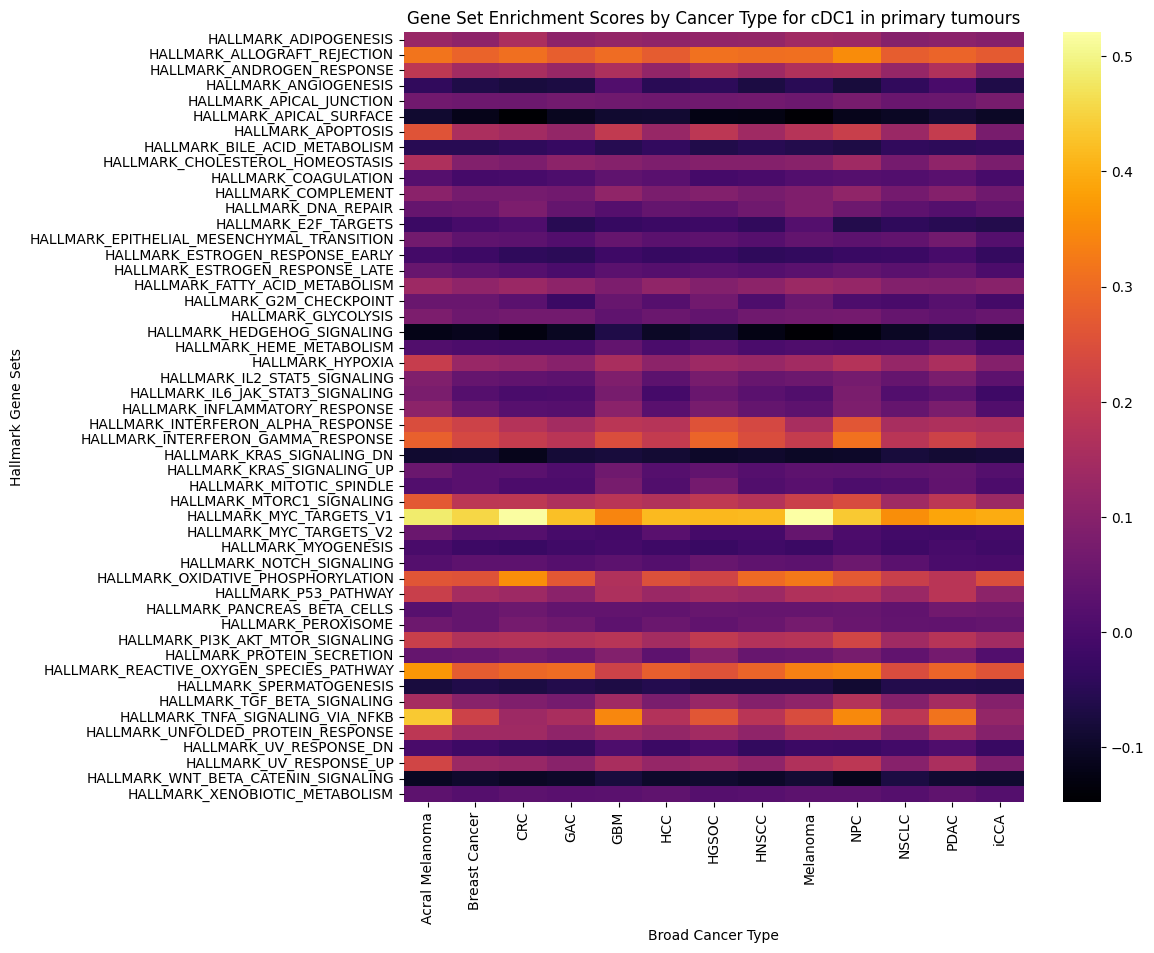

/scratch/temp/11687049/ipykernel_1845247/734714644.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


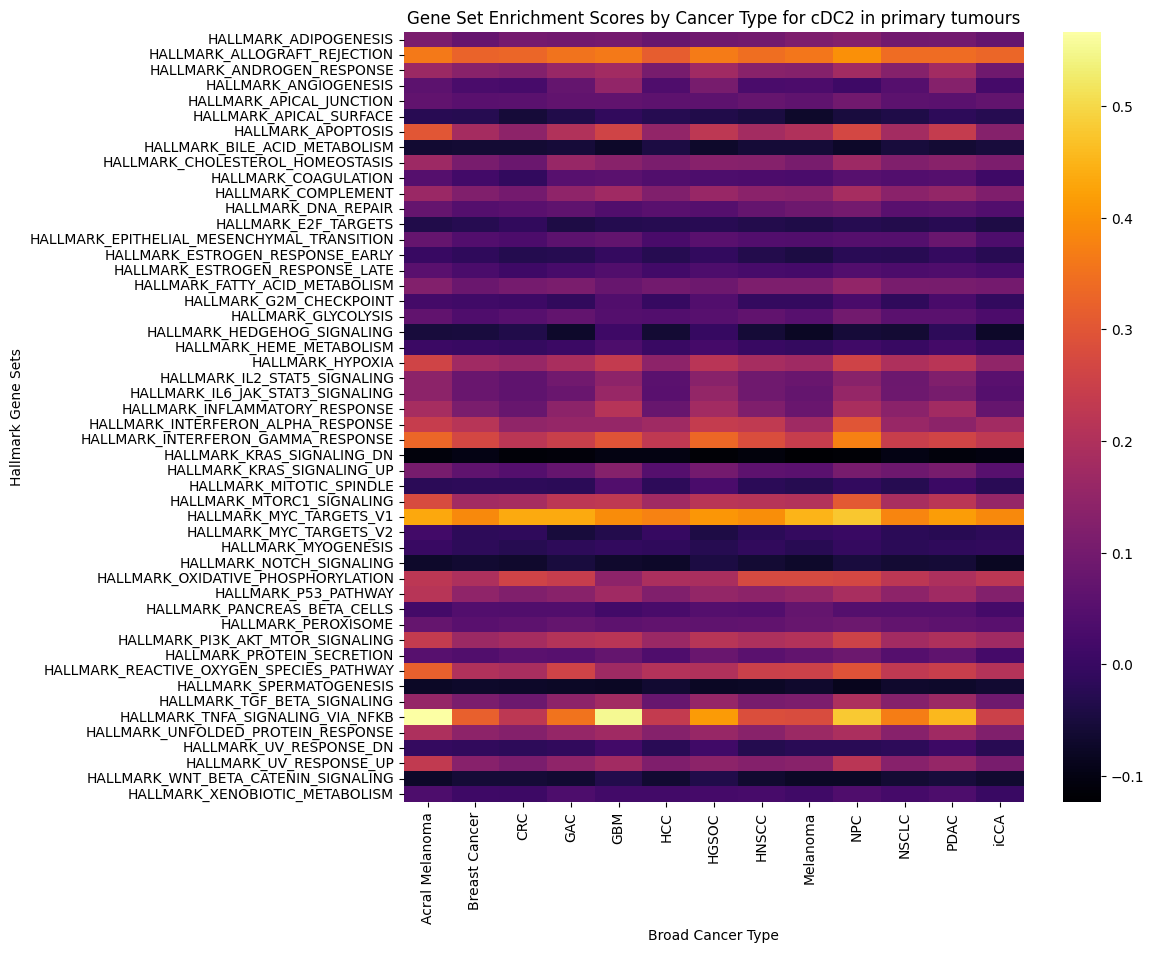

/scratch/temp/11687049/ipykernel_1845247/734714644.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


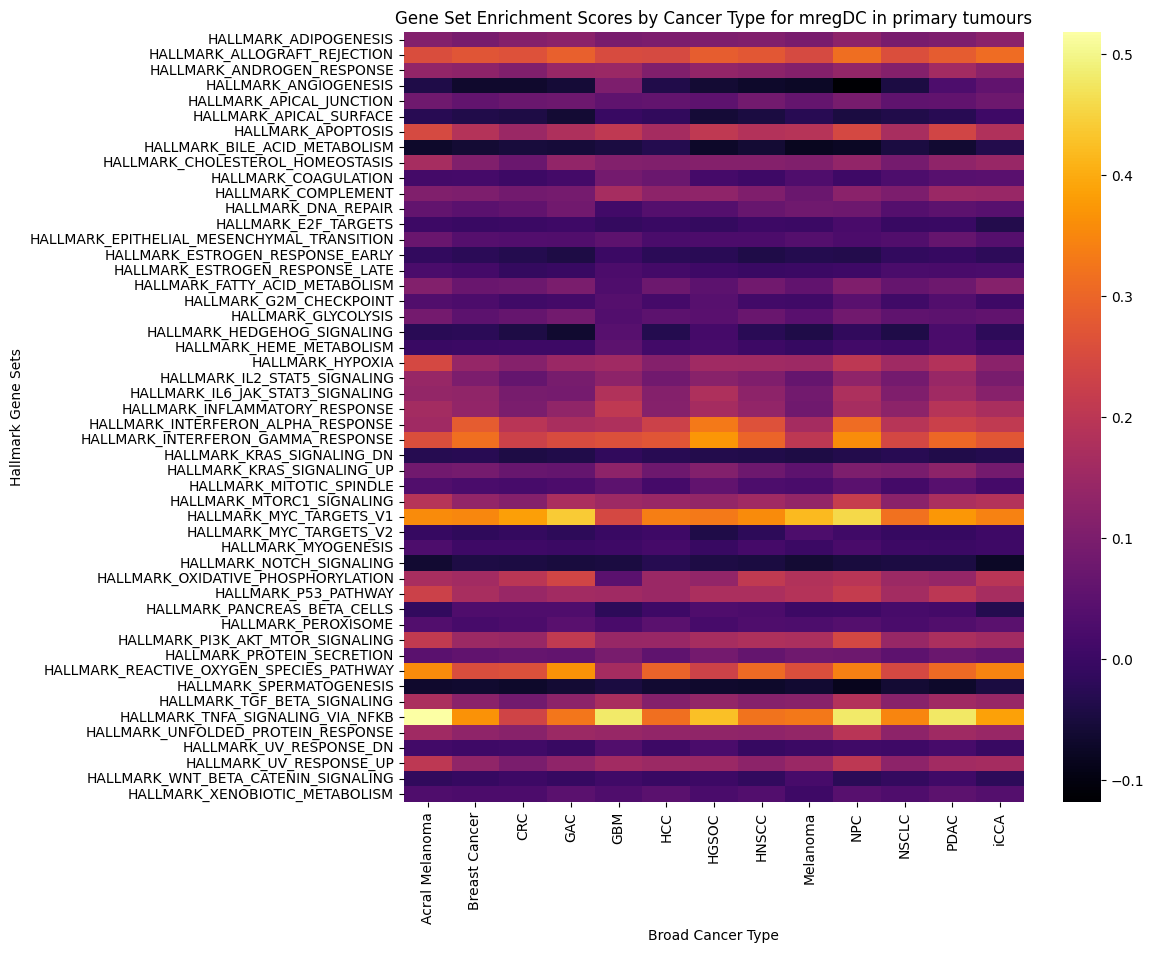

In [19]:
#DC1: 
# Extract gene set scores from `data_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_DC1.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_DC1.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for cDC1 in primary tumours")
plt.show()

#DC2:
# Extract gene set scores from `data_DC2.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_DC2.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_DC2.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for cDC2 in primary tumours")
plt.show()

#mregDC:
# Extract gene set scores from `data_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_mregDC.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_mregDC.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for mregDC in primary tumours")
plt.show()

## repeat for just OC to compare tissues:

In [21]:
data_OC = data[data.obs["cancer_with_H"] == "HGSOC"]

oc_DC1 = data_OC[data_OC.obs["NR_annotations_simple"] == "cDC1"]
oc_DC2 = data_OC[data_OC.obs["NR_annotations_simple"] == "cDC2"]
oc_mregDC = data_OC[data_OC.obs["NR_annotations_simple"] == "mregDC"]

### Score DC subsets by enrichment for each gene set (each dataframe in dictionary)

In [22]:
# Iterate through each gene set in H_sets - DC1
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_DC1, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - DC2
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_DC2, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in H_sets - mregDC
for set_name, gene_set_df in H_sets.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_mregDC, gene_list=gene_set, score_name=f"{set_name}_score")

       'GPAT4', 'LEP', 'MIGA2', 'MRAP', 'MTARC2', 'ORM1', 'SLC66A3', 'SQOR'],
      dtype='object')


       'RARS1', 'TGFB1', 'WARS1'],
      dtype='object')


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'FLNC', 'FYB1', 'KRT31', 'MAP3K20', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'NECTIN4', 'NRAP', 'PALS1', 'PDZD3', 'PECAM1'],
      dtype='object')
       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
      

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'GC', 'HAO1', 'HSD3B1', 'NR0B2', 'NR1H4', 'SERPINA6', 'SOAT2', 'TTR'],
      dtype='object')
       'F11', 'F13B', 'F2', 'F9', 'FGA', 'FGG', 'GDA', 'GP9', 'HMGCS2',
       'HNF4A', 'HRG', 'LEFTY2', 'MBL2', 'MEP1A', 'MMP8', 'PECAM1', 'PLG',
       'PROZ', 'RGN'],
      dtype='object')
       'RBSN'],
      dtype='object')
       'POSTN', 'PRSS2', 'SCG2', 'SGCG', 'TGFB1'],
      dtype='object')
       'RETREG1', 'SEMA3B', 'SOX3'],
      dtype='object')
       'PLAAT3', 'SEMA3B', 'SERPINA5', 'SOX3', 'TH'],
      dtype='object')
       'GAD2', 'GAPDHS', 'H2AZ1', 'HAO2', 'HMGCS2', 'KMT5A', 'MIX23', 'XIST'],
      dtype='object')
       'MAP3K20', 'NSD2', 'PTTG3P', 'TENT4A', 'TGFB1'],
      dtype='object')
       'PGLS', 'RARS1'],
      dtype='object')
       'H1-0', 'H4C3', 'HBBP1', 'HBQ1', 'HBZ', 'MARCHF2', 'MARCHF8', 'PGLS',
       'RHAG', 'SLC30A10', 'SLC4A1', 'SLC66A2', 'SPTA1', 'TENT5C', 'TRIM10',
       'TSPO2', 'TYR'],
      dtype='object')
       'GAPDHS', 'IGFBP1', 'INHA', '

### generate a heatmap of results:

/scratch/temp/11687049/ipykernel_1845247/583581363.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


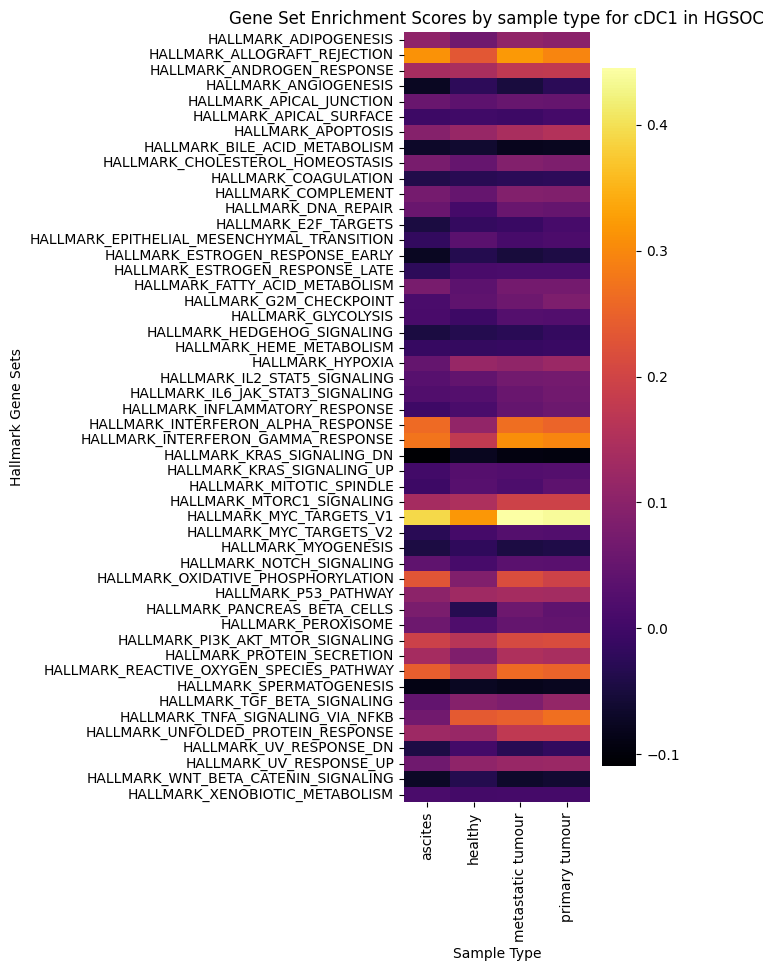

/scratch/temp/11687049/ipykernel_1845247/583581363.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


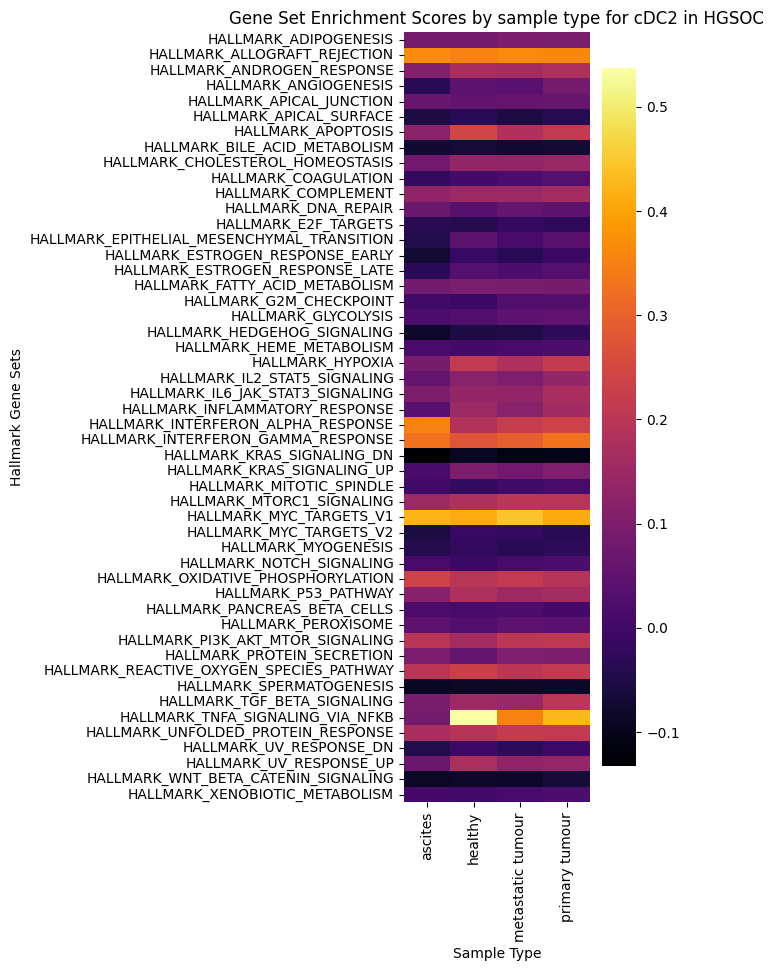

/scratch/temp/11687049/ipykernel_1845247/583581363.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


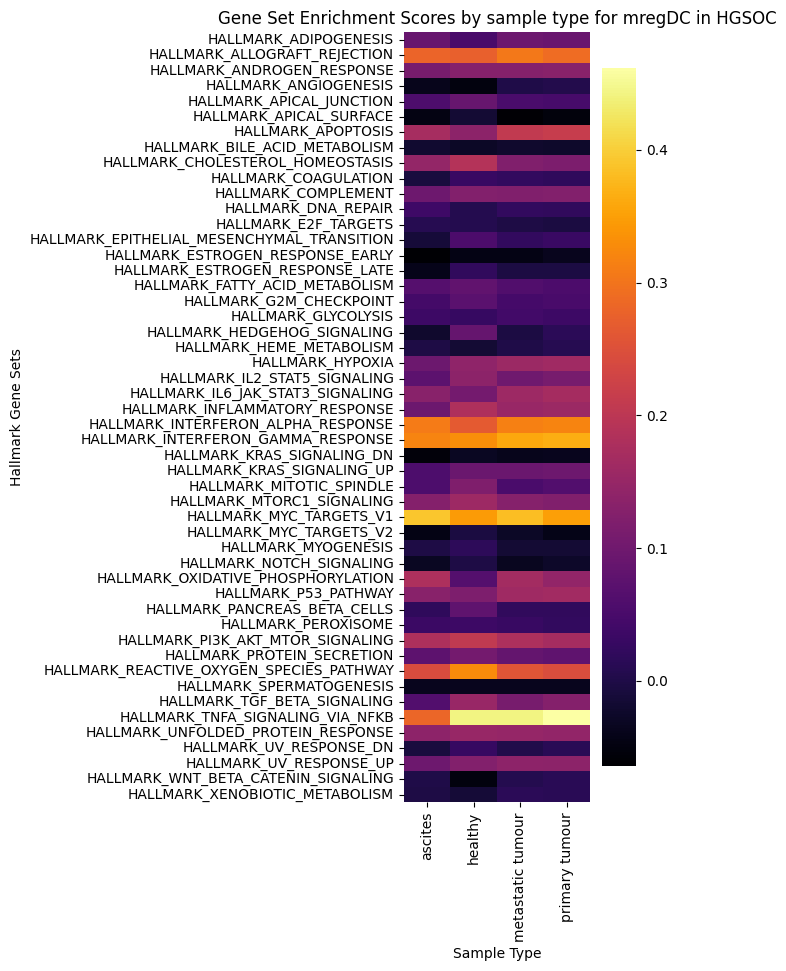

In [27]:
#DC1: 
# Extract gene set scores from `oc_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_DC1.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_DC1.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for cDC1 in HGSOC")
plt.show()

#DC2:
# Extract gene set scores from `oc_DC2.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_DC2.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_DC2.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for cDC2 in HGSOC")
plt.show()

#mregDC:
# Extract gene set scores from `oc_mregDC.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_mregDC.obs[f"{set_name}_score"]
    for set_name in H_sets.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_mregDC.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 10))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Hallmark Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for mregDC in HGSOC")
plt.show()

# Repeat for KEGG pathways

### Import kegg gene sets
* will be imported as a dictionary where each key is a sheet name, and each value is a dataframe (gene set)

In [17]:
os.chdir('/scratch/user/s4436039/scdata/Pathway-sets')
K_sets = pd.read_excel("kegg_sets.xlsx", sheet_name=None)
os.chdir('/scratch/user/s4436039/scdata/Python_Integration_Sep')

In [18]:
# Print the sheet names
print(K_sets.keys())

dict_keys(['Sheet1', 'Sheet2', 'Sheet3', 'Sheet4', 'Sheet5', 'Sheet6', 'Sheet7', 'Sheet8', 'Sheet9', 'Sheet10', 'Sheet11', 'Sheet12', 'Sheet13', 'Sheet14', 'Sheet15', 'Sheet16', 'Sheet17', 'Sheet18', 'Sheet19', 'Sheet20', 'Sheet21', 'Sheet22', 'Sheet23', 'Sheet24', 'Sheet25', 'Sheet26', 'Sheet27', 'Sheet28', 'Sheet29', 'Sheet30', 'Sheet31', 'Sheet32', 'Sheet33', 'Sheet34', 'Sheet35', 'Sheet36', 'Sheet37', 'Sheet38', 'Sheet39', 'Sheet40', 'Sheet41', 'Sheet42', 'Sheet43', 'Sheet44', 'Sheet45', 'Sheet46', 'Sheet47', 'Sheet48', 'Sheet49', 'Sheet50', 'Sheet51', 'Sheet52', 'Sheet53', 'Sheet54', 'Sheet55', 'Sheet56', 'Sheet57', 'Sheet58', 'Sheet59', 'Sheet60', 'Sheet61', 'Sheet62', 'Sheet63', 'Sheet64', 'Sheet65', 'Sheet66', 'Sheet67', 'Sheet68', 'Sheet69', 'Sheet70', 'Sheet71', 'Sheet72', 'Sheet73', 'Sheet74', 'Sheet75', 'Sheet76', 'Sheet77', 'Sheet78', 'Sheet79', 'Sheet80', 'Sheet81', 'Sheet82', 'Sheet83', 'Sheet84', 'Sheet85', 'Sheet86', 'Sheet87', 'Sheet88', 'Sheet89', 'Sheet90', 'Sheet91

In [19]:
# Change keys to be gene set name (the first value in the 'gs_name' column) instead of Sheet1 etc 
K_sets2 = {df["gs_name"].iloc[0]: df for _, df in K_sets.items()}
K_sets = K_sets2

# Result
print(K_sets.keys())

dict_keys(['KEGG_ABC_TRANSPORTERS', 'KEGG_ACUTE_MYELOID_LEUKEMIA', 'KEGG_ADHERENS_JUNCTION', 'KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY', 'KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM', 'KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION', 'KEGG_ALLOGRAFT_REJECTION', 'KEGG_ALPHA_LINOLENIC_ACID_METABOLISM', 'KEGG_ALZHEIMERS_DISEASE', 'KEGG_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM', 'KEGG_AMINOACYL_TRNA_BIOSYNTHESIS', 'KEGG_AMYOTROPHIC_LATERAL_SCLEROSIS_ALS', 'KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION', 'KEGG_APOPTOSIS', 'KEGG_ARACHIDONIC_ACID_METABOLISM', 'KEGG_ARGININE_AND_PROLINE_METABOLISM', 'KEGG_ARRHYTHMOGENIC_RIGHT_VENTRICULAR_CARDIOMYOPATHY_ARVC', 'KEGG_ASCORBATE_AND_ALDARATE_METABOLISM', 'KEGG_ASTHMA', 'KEGG_AUTOIMMUNE_THYROID_DISEASE', 'KEGG_AXON_GUIDANCE', 'KEGG_B_CELL_RECEPTOR_SIGNALING_PATHWAY', 'KEGG_BASAL_CELL_CARCINOMA', 'KEGG_BASAL_TRANSCRIPTION_FACTORS', 'KEGG_BASE_EXCISION_REPAIR', 'KEGG_BETA_ALANINE_METABOLISM', 'KEGG_BIOSYNTHESIS_OF_UNSATURATED_FATTY_ACIDS', 'KEGG_BLADDE

In [20]:
K_sets

{'KEGG_ABC_TRANSPORTERS':    gs_cat gs_subcat                gs_name gene_symbol  entrez_gene  \
 0      C2   CP:KEGG  KEGG_ABC_TRANSPORTERS       ABCA1           19   
 1      C2   CP:KEGG  KEGG_ABC_TRANSPORTERS      ABCA10        10349   
 2      C2   CP:KEGG  KEGG_ABC_TRANSPORTERS      ABCA12        26154   
 3      C2   CP:KEGG  KEGG_ABC_TRANSPORTERS      ABCA13       154664   
 4      C2   CP:KEGG  KEGG_ABC_TRANSPORTERS       ABCA2           20   
 ..    ...       ...                    ...         ...          ...   
 56     C2   CP:KEGG  KEGG_ABC_TRANSPORTERS        TAP2         6891   
 57     C2   CP:KEGG  KEGG_ABC_TRANSPORTERS        TAP2         6891   
 58     C2   CP:KEGG  KEGG_ABC_TRANSPORTERS        TAP2         6891   
 59     C2   CP:KEGG  KEGG_ABC_TRANSPORTERS        TAP2         6891   
 60     C2   CP:KEGG  KEGG_ABC_TRANSPORTERS        TAP2         6891   
 
        ensembl_gene human_gene_symbol  human_entrez_gene human_ensembl_gene  \
 0   ENSG00000165029         

### Remove unwanted sets so only select sets remain

In [21]:
# Keys to include in new dictionary
keys_include = ["KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY",
"KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION",
"KEGG_APOPTOSIS",
"KEGG_CALCIUM_SIGNALING_PATHWAY",
"KEGG_CELL_ADHESION_MOLECULES_CAMS",
"KEGG_CHEMOKINE_SIGNALING_PATHWAY",
"KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION",
"KEGG_CYTOSOLIC_DNA_SENSING_PATHWAY",
"KEGG_ENDOCYTOSIS",
"KEGG_FATTY_ACID_METABOLISM",
"KEGG_FC_GAMMA_R_MEDIATED_PHAGOCYTOSIS",
"KEGG_GLYCOLYSIS_GLUCONEOGENESIS",
"KEGG_JAK_STAT_SIGNALING_PATHWAY",
"KEGG_MAPK_SIGNALING_PATHWAY",
"KEGG_NOD_LIKE_RECEPTOR_SIGNALING_PATHWAY",
"KEGG_NOTCH_SIGNALING_PATHWAY",
"KEGG_OXIDATIVE_PHOSPHORYLATION",
"KEGG_PROTEASOME",
"KEGG_PROTEIN_EXPORT",
"KEGG_TGF_BETA_SIGNALING_PATHWAY",
"KEGG_TOLL_LIKE_RECEPTOR_SIGNALING_PATHWAY",
"KEGG_TYROSINE_METABOLISM",
"KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS",
"KEGG_VEGF_SIGNALING_PATHWAY"]

In [22]:
# create a new dictionary with select keys (pathway sets)
K_sets_sub = {key: K_sets[key] for key in keys_include if key in K_sets}

# Display the new dictionary
K_sets_sub

{'KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY':    gs_cat gs_subcat                               gs_name gene_symbol  \
 0      C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY       ACACB   
 1      C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY       ACSL1   
 2      C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY       ACSL3   
 3      C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY       ACSL4   
 4      C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY       ACSL5   
 ..    ...       ...                                   ...         ...   
 80     C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY         TNF   
 81     C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY    TNFRSF1A   
 82     C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY    TNFRSF1B   
 83     C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY       TRADD   
 84     C2   CP:KEGG  KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY       TRAF2   
 
     entrez_gene     ensembl_gene human_gene_symbol  human_entrez_gene

## Seperate data into each DC subset

In [23]:
data_P = data[data.obs["sample_type_major2"] == "primary tumour"]

data_DC1 = data_P[data_P.obs["NR_annotations_simple"] == "cDC1"]
data_DC2 = data_P[data_P.obs["NR_annotations_simple"] == "cDC2"]
data_mregDC = data_P[data_P.obs["NR_annotations_simple"] == "mregDC"]

## Score DC subsets by enrichment for each gene set (each dataframe in dictionary)

In [24]:
# Iterate through each gene set in K_sets_sub - DC1
for set_name, gene_set_df in K_sets_sub.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_DC1, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in K_sets_sub - DC2
for set_name, gene_set_df in K_sets_sub.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_DC2, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in K_sets_sub - mregDC
for set_name, gene_set_df in K_sets_sub.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(data_mregDC, gene_list=gene_set, score_name=f"{set_name}_score")

       'PRKAG3'],
      dtype='object')
       'IFNA17', 'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7',
       'IFNA8', 'KIR2DL2', 'KIR2DL5A', 'KIR2DS1', 'KIR2DS3', 'KIR2DS4',
       'KIR2DS5'],
      dtype='object')


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'AVPR1B', 'BDKRB1', 'CACNA1B', 'CACNA1E', 'CACNA1S', 'CAMK2A', 'CCKAR',
       'CCKBR', 'CHP2', 'CHRM1', 'CHRM2', 'CHRM5', 'DRD1', 'DRD5', 'GRM1',
       'GRM5', 'GRPR', 'HTR2A', 'HTR2C', 'HTR4', 'HTR5A', 'HTR6', 'LHCGR',
       'MYLK3', 'P2RX3', 'PLCZ1', 'PLN', 'PPP3R2', 'PRKACG', 'PTGFR',
       'SLC25A31', 'TACR3', 'TRHR', 'VDAC2P5'],
      dtype='object')
       'CLDN8', 'HLA-DRB3', 'HLA-DRB4', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'PECAM1'],
      dtype='object')
       'CCL3L3', 'CXCL8', 'GNG13', 'GRK1', 'GRK2', 'GRK3', 'PPBPP1', 'PRKACG'],
      dtype='object')
       'EPO', 'GH2', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17',
       'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNK',
       'IFNL2', 'IFNL3', 'IFNW1', 'IL17B', 'IL25', 'IL3', 'IL4', 'IL5', 'IL9',
       'INHBC', 'LEP', 'PPBPP1', 'PRL', 'TGFB1', 'TNFRSF6B', 'VEGFD'],
      dtype='object')
       'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'STING1'],
      dtype=

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'AVPR1B', 'BDKRB1', 'CACNA1B', 'CACNA1E', 'CACNA1S', 'CAMK2A', 'CCKAR',
       'CCKBR', 'CHP2', 'CHRM1', 'CHRM2', 'CHRM5', 'DRD1', 'DRD5', 'GRM1',
       'GRM5', 'GRPR', 'HTR2A', 'HTR2C', 'HTR4', 'HTR5A', 'HTR6', 'LHCGR',
       'MYLK3', 'P2RX3', 'PLCZ1', 'PLN', 'PPP3R2', 'PRKACG', 'PTGFR',
       'SLC25A31', 'TACR3', 'TRHR', 'VDAC2P5'],
      dtype='object')
       'CLDN8', 'HLA-DRB3', 'HLA-DRB4', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'PECAM1'],
      dtype='object')
       'CCL3L3', 'CXCL8', 'GNG13', 'GRK1', 'GRK2', 'GRK3', 'PPBPP1', 'PRKACG'],
      dtype='object')
       'EPO', 'GH2', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17',
       'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNK',
       'IFNL2', 'IFNL3', 'IFNW1', 'IL17B', 'IL25', 'IL3', 'IL4', 'IL5', 'IL9',
       'INHBC', 'LEP', 'PPBPP1', 'PRL', 'TGFB1', 'TNFRSF6B', 'VEGFD'],
      dtype='object')
       'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'STING1'],
      dtype=

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'CLDN8', 'HLA-DRB3', 'HLA-DRB4', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'PECAM1'],
      dtype='object')
       'CCL3L3', 'CXCL8', 'GNG13', 'GRK1', 'GRK2', 'GRK3', 'PPBPP1', 'PRKACG'],
      dtype='object')
       'EPO', 'GH2', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17',
       'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNK',
       'IFNL2', 'IFNL3', 'IFNW1', 'IL17B', 'IL25', 'IL3', 'IL4', 'IL5', 'IL9',
       'INHBC', 'LEP', 'PPBPP1', 'PRL', 'TGFB1', 'TNFRSF6B', 'VEGFD'],
      dtype='object')
       'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'STING1'],
      dtype='object')
       'G6PC2', 'LDHAL6B', 'PCK1', 'PDHA2', 'PGAM4', 'PGK2', 'PKLR'],
      dtype='object')
       'IFNA17', 'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7',
       'IFNA8', 'IFNK', 'IFNL2', 'IFNL3', 'IFNW1', 'IL3', 'IL4', 'IL5', 'IL9',
       'LEP', 'PRL'],
      dtype='object')
       'CACNG6', 'CACNG7', 'CHP2', 'FGF10', 'FGF16', 'FGF20', 'FGF21', '

### Perform ANOVA

In [25]:
# cDC1:

# Initialize a results dictionary to store p-values
stats_results = {}

# Iterate through each gene set
for set_name in K_sets_sub.keys():
    # Extract the scores and corresponding cancer types
    scores = data_DC1.obs[f"{set_name}_score"]
    cancer_types = data_DC1.obs["cancer_type_broad"]

    # Perform ANOVA
    groups = [scores[cancer_types == ct] for ct in cancer_types.unique()]
    f_stat, p_value = stats.f_oneway(*groups)

    # Save the results
    stats_results[set_name] = {
        "p_value": p_value,
        "f_stat": f_stat
    }

    # Perform post-hoc test if p_value is significant
    if p_value < 0.05:
        posthoc = pairwise_tukeyhsd(endog=scores, groups=cancer_types, alpha=0.05)
        print(f"Post-hoc results for {set_name}:")
        print(posthoc)

# Convert the results to a dataframe for easier viewing
results_df = pd.DataFrame(stats_results).T
print(results_df)

Post-hoc results for KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Acral Melanoma Breast Cancer  -0.0606    0.0   -0.09 -0.0312   True
Acral Melanoma           CRC  -0.0758    0.0 -0.1166  -0.035   True
Acral Melanoma           GAC  -0.0626    0.0 -0.1016 -0.0236   True
Acral Melanoma           GBM  -0.0329 0.0224 -0.0635 -0.0023   True
Acral Melanoma           HCC   -0.068    0.0 -0.1001 -0.0359   True
Acral Melanoma         HGSOC  -0.0524    0.0 -0.0815 -0.0234   True
Acral Melanoma         HNSCC  -0.0565    0.0 -0.0852 -0.0279   True
Acral Melanoma      Melanoma  -0.0395 0.1555 -0.0846  0.0055  False
Acral Melanoma           NPC  -0.0443 0.0014 -0.0786 -0.0099   True
Acral Melanoma         NSCLC   -0.062    0.0 -0.0912 -0.0329   True
Acral Melanoma          PDAC  -0.0696    0.0 -0.1096 -0.0

In [26]:
# cDC2:

# Initialize a results dictionary to store p-values
stats_results = {}

# Iterate through each gene set
for set_name in K_sets_sub.keys():
    # Extract the scores and corresponding cancer types
    scores = data_DC2.obs[f"{set_name}_score"]
    cancer_types = data_DC2.obs["cancer_type_broad"]

    # Perform ANOVA
    groups = [scores[cancer_types == ct] for ct in cancer_types.unique()]
    f_stat, p_value = stats.f_oneway(*groups)

    # Save the results
    stats_results[set_name] = {
        "p_value": p_value,
        "f_stat": f_stat
    }

    # Perform post-hoc test if p_value is significant
    if p_value < 0.05:
        posthoc = pairwise_tukeyhsd(endog=scores, groups=cancer_types, alpha=0.05)
        print(f"Post-hoc results for {set_name}:")
        print(posthoc)

# Convert the results to a dataframe for easier viewing
results_df = pd.DataFrame(stats_results).T
print(results_df)

Post-hoc results for KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Acral Melanoma Breast Cancer  -0.0513    0.0 -0.0728 -0.0298   True
Acral Melanoma           CRC  -0.0561    0.0 -0.0851 -0.0271   True
Acral Melanoma           GAC  -0.0405    0.0 -0.0665 -0.0145   True
Acral Melanoma           GBM   0.0098 0.9641 -0.0125  0.0321  False
Acral Melanoma           HCC  -0.0613    0.0 -0.0842 -0.0384   True
Acral Melanoma         HGSOC  -0.0179 0.2194 -0.0394  0.0036  False
Acral Melanoma         HNSCC  -0.0494    0.0 -0.0705 -0.0282   True
Acral Melanoma      Melanoma  -0.0643    0.0 -0.0991 -0.0294   True
Acral Melanoma           NPC   -0.032 0.0061 -0.0591 -0.0049   True
Acral Melanoma         NSCLC   -0.038    0.0 -0.0592 -0.0167   True
Acral Melanoma          PDAC  -0.0186 0.2897  -0.042  0.0

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1260: IntegrationWarning: The integral is probably divergent, or slowly convergent.


Post-hoc results for KEGG_CHEMOKINE_SIGNALING_PATHWAY:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Acral Melanoma Breast Cancer  -0.0318    0.0 -0.0485  -0.015   True
Acral Melanoma           CRC  -0.0439    0.0 -0.0664 -0.0214   True
Acral Melanoma           GAC  -0.0272 0.0006 -0.0474 -0.0071   True
Acral Melanoma           GBM   0.0204 0.0063  0.0031  0.0377   True
Acral Melanoma           HCC   -0.044    0.0 -0.0618 -0.0262   True
Acral Melanoma         HGSOC   0.0099 0.7486 -0.0067  0.0266  False
Acral Melanoma         HNSCC    -0.03    0.0 -0.0464 -0.0136   True
Acral Melanoma      Melanoma  -0.0332 0.0032 -0.0603 -0.0062   True
Acral Melanoma           NPC   0.0069 0.9971 -0.0141   0.028  False
Acral Melanoma         NSCLC   -0.024 0.0001 -0.0405 -0.0075   True
Acral Melanoma          PDAC  -0.0137 0.3747 -0.0318  0.0045 

In [27]:
# mregDC:

# Initialize a results dictionary to store p-values
stats_results = {}

# Iterate through each gene set
for set_name in K_sets_sub.keys():
    # Extract the scores and corresponding cancer types
    scores = data_mregDC.obs[f"{set_name}_score"]
    cancer_types = data_mregDC.obs["cancer_type_broad"]

    # Perform ANOVA
    groups = [scores[cancer_types == ct] for ct in cancer_types.unique()]
    f_stat, p_value = stats.f_oneway(*groups)

    # Save the results
    stats_results[set_name] = {
        "p_value": p_value,
        "f_stat": f_stat
    }

    # Perform post-hoc test if p_value is significant
    if p_value < 0.05:
        posthoc = pairwise_tukeyhsd(endog=scores, groups=cancer_types, alpha=0.05)
        print(f"Post-hoc results for {set_name}:")
        print(posthoc)

# Convert the results to a dataframe for easier viewing
results_df = pd.DataFrame(stats_results).T
print(results_df)

Post-hoc results for KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2    meandiff p-adj   lower   upper  reject
-------------------------------------------------------------------
Acral Melanoma Breast Cancer  -0.0532    0.0 -0.0803 -0.0261   True
Acral Melanoma           CRC  -0.0749    0.0  -0.111 -0.0388   True
Acral Melanoma           GAC  -0.0587    0.0 -0.0892 -0.0281   True
Acral Melanoma           GBM  -0.0143 0.9728 -0.0479  0.0193  False
Acral Melanoma           HCC  -0.0764    0.0  -0.113 -0.0398   True
Acral Melanoma         HGSOC  -0.0294 0.0189 -0.0563 -0.0024   True
Acral Melanoma         HNSCC  -0.0533    0.0 -0.0792 -0.0273   True
Acral Melanoma      Melanoma   -0.047 0.6811 -0.1219   0.028  False
Acral Melanoma           NPC  -0.0232 0.2557 -0.0518  0.0053  False
Acral Melanoma         NSCLC  -0.0579    0.0 -0.0848 -0.0309   True
Acral Melanoma          PDAC  -0.0381 0.0666 -0.0773  0.0

### generate a heatmap of results:

/scratch/temp/11785178/ipykernel_242198/1239375556.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


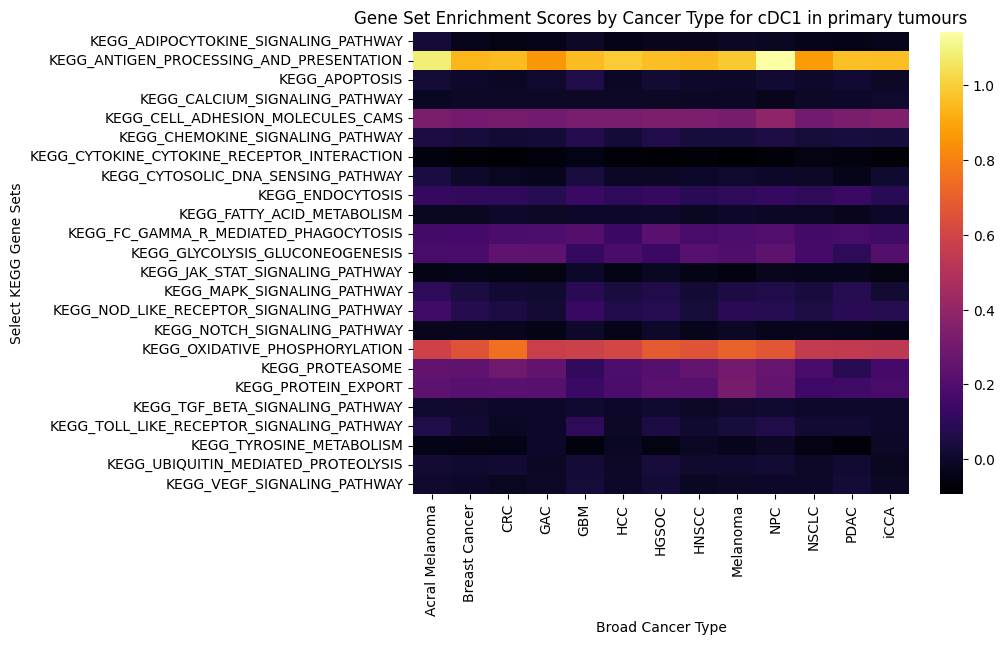

/scratch/temp/11785178/ipykernel_242198/1239375556.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


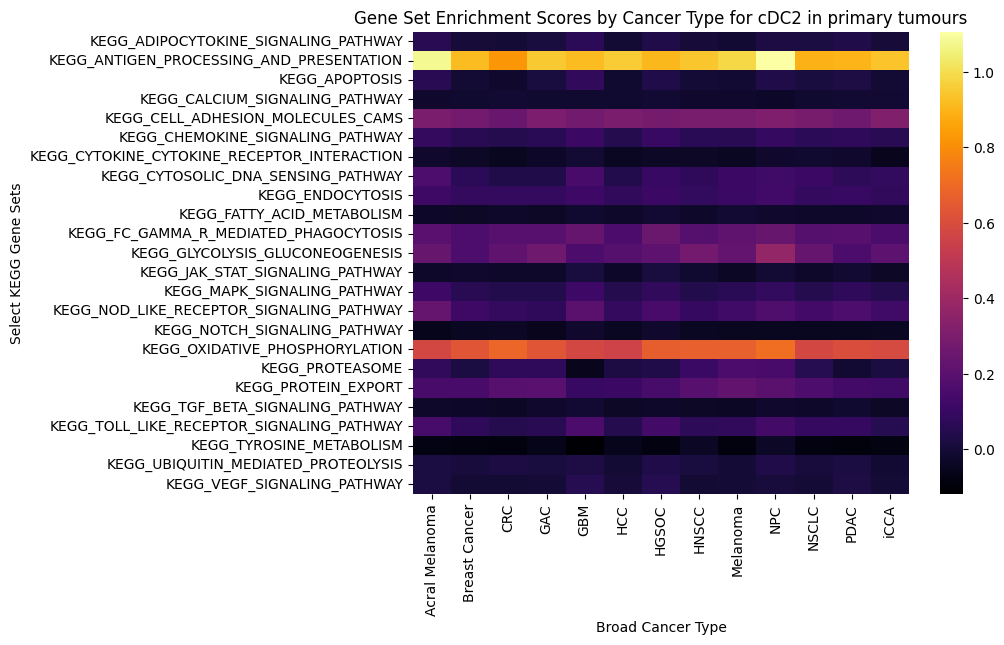

/scratch/temp/11785178/ipykernel_242198/1239375556.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


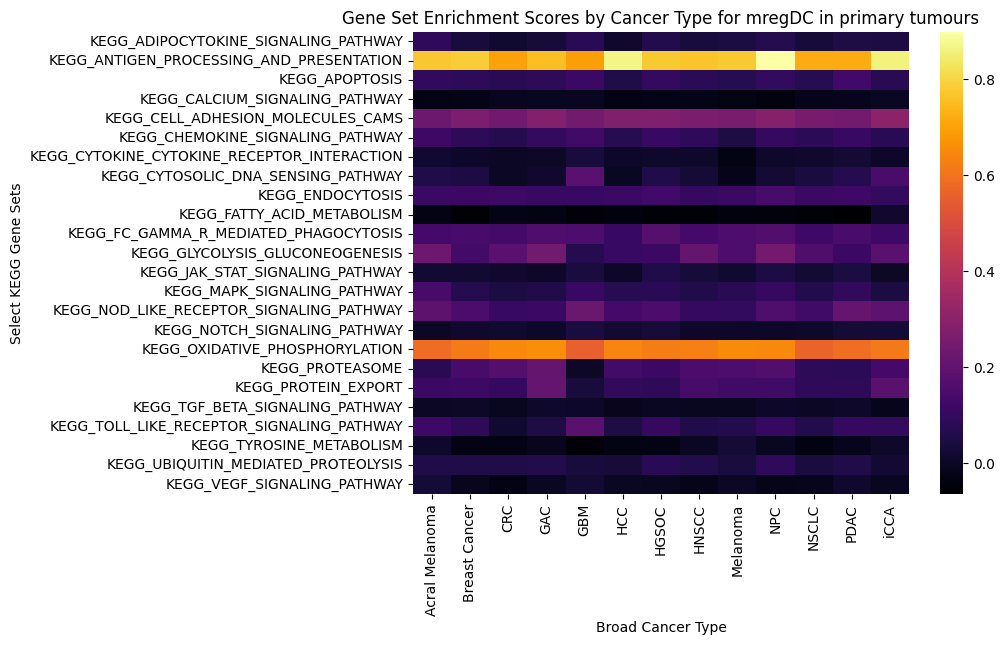

In [21]:
#DC1: 
# Extract gene set scores from `data_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_DC1.obs[f"{set_name}_score"]
    for set_name in K_sets_sub.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_DC1.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Select KEGG Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for cDC1 in primary tumours")
plt.show()

#DC2:
# Extract gene set scores from `data_DC2.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_DC2.obs[f"{set_name}_score"]
    for set_name in K_sets_sub.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_DC2.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Select KEGG Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for cDC2 in primary tumours")
plt.show()

#mregDC:
# Extract gene set scores from `data_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: data_mregDC.obs[f"{set_name}_score"]
    for set_name in K_sets_sub.keys()
})

# Add the cancer_type_broad metadata as a column
gene_set_scores["cancer_type_broad"] = data_mregDC.obs["cancer_type_broad"].values

# Group by cancer_type_broad and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("cancer_type_broad").mean().T

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Broad Cancer Type")
plt.ylabel("Select KEGG Gene Sets")
plt.title("Gene Set Enrichment Scores by Cancer Type for mregDC in primary tumours")
plt.show()

## repeat for just OC to compare tissues:

In [23]:
data_OC = data[data.obs["cancer_with_H"] == "HGSOC"]

oc_DC1 = data_OC[data_OC.obs["NR_annotations_simple"] == "cDC1"]
oc_DC2 = data_OC[data_OC.obs["NR_annotations_simple"] == "cDC2"]
oc_mregDC = data_OC[data_OC.obs["NR_annotations_simple"] == "mregDC"]

### Score DC subsets by enrichment for each gene set (each dataframe in dictionary)

In [24]:
# Iterate through each gene set in K_sets_sub - DC1
for set_name, gene_set_df in K_sets_sub.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_DC1, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in K_sets_sub - DC2
for set_name, gene_set_df in K_sets_sub.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_DC2, gene_list=gene_set, score_name=f"{set_name}_score")

# Iterate through each gene set in K_sets_sub - mregDC
for set_name, gene_set_df in K_sets_sub.items():
    # Extract the gene set from the 'gene_symbol' column of the dataframe
    gene_set = gene_set_df['gene_symbol'].tolist()
    
    # Score the cells using the gene set
    sc.tl.score_genes(oc_mregDC, gene_list=gene_set, score_name=f"{set_name}_score")

       'PRKAG3'],
      dtype='object')
       'IFNA17', 'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7',
       'IFNA8', 'KIR2DL2', 'KIR2DL5A', 'KIR2DS1', 'KIR2DS3', 'KIR2DS4',
       'KIR2DS5'],
      dtype='object')
       'AVPR1B', 'BDKRB1', 'CACNA1B', 'CACNA1E', 'CACNA1S', 'CAMK2A', 'CCKAR',
       'CCKBR', 'CHP2', 'CHRM1', 'CHRM2', 'CHRM5', 'DRD1', 'DRD5', 'GRM1',
       'GRM5', 'GRPR', 'HTR2A', 'HTR2C', 'HTR4', 'HTR5A', 'HTR6', 'LHCGR',
       'MYLK3', 'P2RX3', 'PLCZ1', 'PLN', 'PPP3R2', 'PRKACG', 'PTGFR',
       'SLC25A31', 'TACR3', 'TRHR', 'VDAC2P5'],
      dtype='object')


/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'CLDN8', 'HLA-DRB3', 'HLA-DRB4', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'PECAM1'],
      dtype='object')
       'CCL3L3', 'CXCL8', 'GNG13', 'GRK1', 'GRK2', 'GRK3', 'PPBPP1', 'PRKACG'],
      dtype='object')
       'EPO', 'GH2', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17',
       'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNK',
       'IFNL2', 'IFNL3', 'IFNW1', 'IL17B', 'IL25', 'IL3', 'IL4', 'IL5', 'IL9',
       'INHBC', 'LEP', 'PPBPP1', 'PRL', 'TGFB1', 'TNFRSF6B', 'VEGFD'],
      dtype='object')
       'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'STING1'],
      dtype='object')
       'G6PC2', 'LDHAL6B', 'PCK1', 'PDHA2', 'PGAM4', 'PGK2', 'PKLR'],
      dtype='object')
       'IFNA17', 'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7',
       'IFNA8', 'IFNK', 'IFNL2', 'IFNL3', 'IFNW1', 'IL3', 'IL4', 'IL5', 'IL9',
       'LEP', 'PRL'],
      dtype='object')
       'CACNG6', 'CACNG7', 'CHP2', 'FGF10', 'FGF16', 'FGF20', 'FGF21', '

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'AVPR1B', 'BDKRB1', 'CACNA1B', 'CACNA1E', 'CACNA1S', 'CAMK2A', 'CCKAR',
       'CCKBR', 'CHP2', 'CHRM1', 'CHRM2', 'CHRM5', 'DRD1', 'DRD5', 'GRM1',
       'GRM5', 'GRPR', 'HTR2A', 'HTR2C', 'HTR4', 'HTR5A', 'HTR6', 'LHCGR',
       'MYLK3', 'P2RX3', 'PLCZ1', 'PLN', 'PPP3R2', 'PRKACG', 'PTGFR',
       'SLC25A31', 'TACR3', 'TRHR', 'VDAC2P5'],
      dtype='object')
       'CLDN8', 'HLA-DRB3', 'HLA-DRB4', 'NECTIN1', 'NECTIN2', 'NECTIN3',
       'PECAM1'],
      dtype='object')
       'CCL3L3', 'CXCL8', 'GNG13', 'GRK1', 'GRK2', 'GRK3', 'PPBPP1', 'PRKACG'],
      dtype='object')
       'EPO', 'GH2', 'IFNA1', 'IFNA10', 'IFNA13', 'IFNA14', 'IFNA16', 'IFNA17',
       'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'IFNK',
       'IFNL2', 'IFNL3', 'IFNW1', 'IL17B', 'IL25', 'IL3', 'IL4', 'IL5', 'IL9',
       'INHBC', 'LEP', 'PPBPP1', 'PRL', 'TGFB1', 'TNFRSF6B', 'VEGFD'],
      dtype='object')
       'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'STING1'],
      dtype=

/home/s4436039/miniforge3/envs/env/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


       'G6PC2', 'LDHAL6B', 'PCK1', 'PDHA2', 'PGAM4', 'PGK2', 'PKLR'],
      dtype='object')
       'IFNA17', 'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7',
       'IFNA8', 'IFNK', 'IFNL2', 'IFNL3', 'IFNW1', 'IL3', 'IL4', 'IL5', 'IL9',
       'LEP', 'PRL'],
      dtype='object')
       'CACNG6', 'CACNG7', 'CHP2', 'FGF10', 'FGF16', 'FGF20', 'FGF21', 'FGF23',
       'FGF3', 'FGF4', 'FGF5', 'FGF6', 'FLNC', 'JMJD7-PLA2G4B', 'MAP3K14',
       'MAP3K20', 'MOS', 'NGF', 'PLA2G12B', 'PLA2G2A', 'PLA2G2C', 'PLA2G2E',
       'PLA2G2F', 'PPP3R2', 'PRKACG', 'PTPN5', 'TGFB1'],
      dtype='object')
       'ATP5MC1', 'ATP5MC1P5', 'ATP5MC2', 'ATP5MC3', 'ATP5ME', 'ATP5MF',
       'ATP5MG', 'ATP5PB', 'ATP5PD', 'ATP5PF', 'ATP5PO', 'ATP6V1G3', 'COX6A2',
       'COX6CP3', 'COX7B2', 'COX8C', 'UQCR10P1', 'UQCRHL'],
      dtype='object')
       'TGFB1'],
      dtype='object')
       'IFNA2', 'IFNA21', 'IFNA4', 'IFNA5', 'IFNA6', 'IFNA7', 'IFNA8', 'LBP'],
      dtype='object')
       'NAA80', 'TAT', 'TH',

### generate a heatmap of results:

/scratch/temp/11785178/ipykernel_242198/1920013601.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


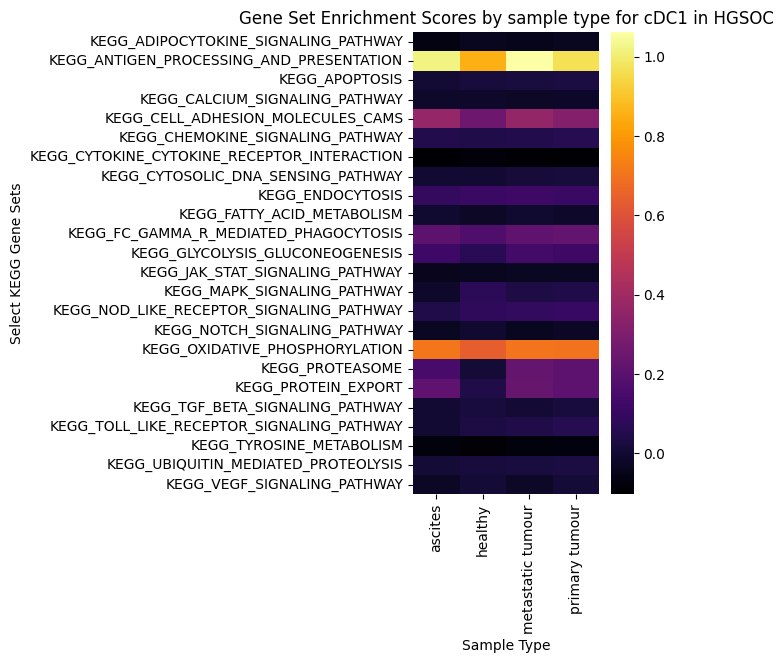

/scratch/temp/11785178/ipykernel_242198/1920013601.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


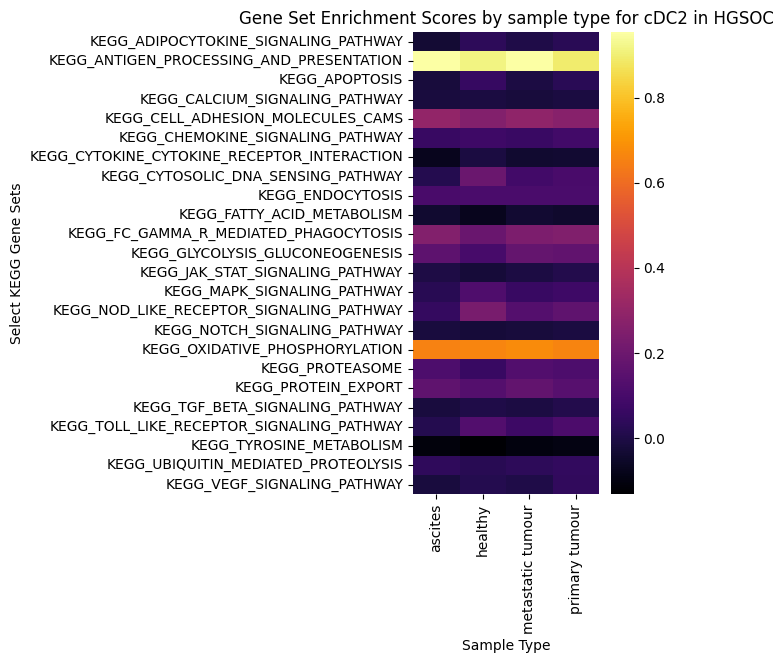

/scratch/temp/11785178/ipykernel_242198/1920013601.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


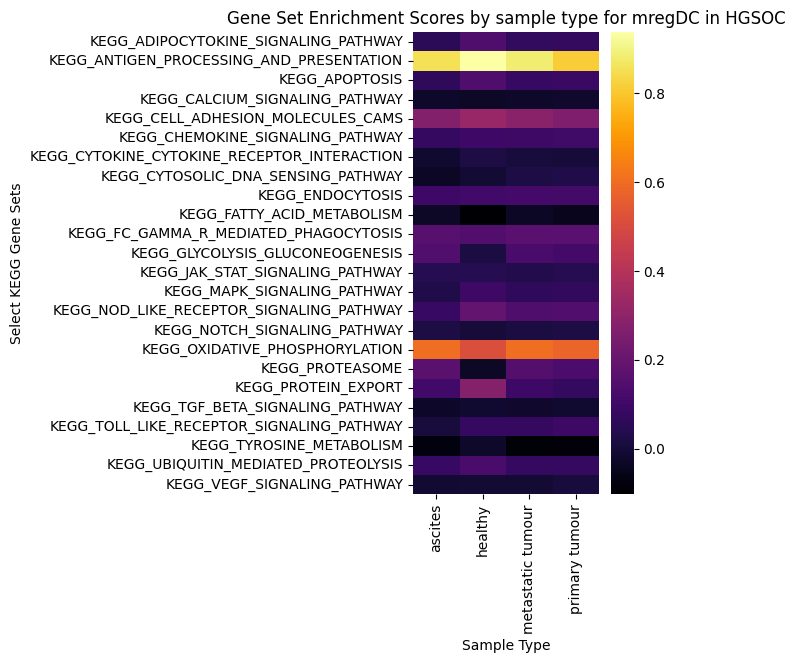

In [27]:
#DC1: 
# Extract gene set scores from `oc_DC1.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_DC1.obs[f"{set_name}_score"]
    for set_name in K_sets_sub.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_DC1.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 6))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Select KEGG Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for cDC1 in HGSOC")
plt.show()

#DC2:
# Extract gene set scores from `oc_DC2.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_DC2.obs[f"{set_name}_score"]
    for set_name in K_sets_sub.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_DC2.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 6))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Select KEGG Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for cDC2 in HGSOC")
plt.show()

#mregDC:
# Extract gene set scores from `oc_mregDC.obs`
gene_set_scores = pd.DataFrame({
    set_name: oc_mregDC.obs[f"{set_name}_score"]
    for set_name in K_sets_sub.keys()
})

# Add the sample_type_major2 metadata as a column
gene_set_scores["sample_type_major2"] = oc_mregDC.obs["sample_type_major2"].values

# Group by sample_type_major2 and compute mean scores for each group
grouped_scores = gene_set_scores.groupby("sample_type_major2").mean().T

# Plot the heatmap
plt.figure(figsize=(3, 6))
sns.heatmap(grouped_scores, cmap="inferno", yticklabels=True, xticklabels=True)
plt.xlabel("Sample Type")
plt.ylabel("Select KEGG Gene Sets")
plt.title("Gene Set Enrichment Scores by sample type for mregDC in HGSOC")
plt.show()